In [ ]:
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load fake and true datasets
fake_df = pd.read_csv('Dataset/DataSet_Misinfo_FAKE.csv')
true_df = pd.read_csv('Dataset/DataSet_Misinfo_TRUE.csv')

In [3]:
fake_df.head()

,Unnamed: 0,text
0,0,Donald Trump just couldn t wish all Americans ...
1,1,House Intelligence Committee Chairman Devin Nu...
2,2,"On Friday, it was revealed that former Milwauk..."
3,3,"On Christmas day, Donald Trump announced that ..."
4,4,Pope Francis used his annual Christmas Day mes...


In [4]:
true_df.head()

,Unnamed: 0,text
0,0,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,2,The special counsel investigation of links bet...
3,3,Trump campaign adviser George Papadopoulos tol...
4,4,President Donald Trump called on the U.S. Post...


In [5]:
# The Unnamed column is not needed for analysis, so we drop it
fake_df.drop('Unnamed: 0', axis=1, inplace=True)
true_df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
fake_df['label'] = 0  # 0 for fake
true_df['label'] = 1  # 1 for true
fake_df.dropna(inplace=True)
true_df.dropna(inplace=True)

In [7]:
combined_df = pd.concat([fake_df, true_df], ignore_index=True)

In [8]:
print(combined_df['label'].value_counts())

label
0    43642
1    34946
Name: count, dtype: int64


In [9]:
combined_df.isnull().sum()

text     0
label    0
dtype: int64

In [10]:
combined_df.duplicated().sum()

9984

In [11]:
combined_df=combined_df.drop_duplicates()

In [12]:

print(combined_df['label'].value_counts())

label
1    34526
0    34078
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Fake and True News')

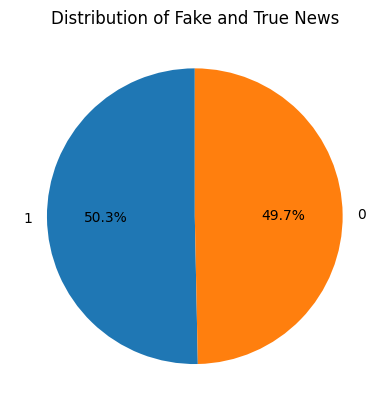

In [13]:
pie_chart = combined_df['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
pie_chart.set_ylabel('')  # Remove the y-label
pie_chart.set_title('Distribution of Fake and True News')

# Pre Processsing of Data


In [14]:
from nltk.stem import WordNetLemmatizer

# For NLTK operations
stop_words = set(nltk.corpus.stopwords.words('english'))
extra_chars = "‘“”’–•—´…–«»©®→←"
char_translation = str.maketrans('', '', string.punctuation + string.digits + "‘“”"+extra_chars)


lemmatizer = WordNetLemmatizer() 
custom_stopwords = [
    "said", "mr", "say", "one", "would", "could", "also", 
    "new", "report", "news", "people", "u", "said", "say", "told", "make", "get", "know", "want", "work", "think", 
    "see", "come", "need", "take", "much", "still", "even", "according", 
    "way", "back", "day", "year", "week", "time", "month", "thing", "first", 
    "last", "many", "more", "good", "well", "life", "things", "find", "go", 
    "ask", "should", "will", "have", "can", "could", "would", "might", "is", 
    "are", "was", "were", "be", "being", "been", "you", "i", "me", "he", "she", 
    "it", "we", "they", "them", "us", "your", "my", "our", "their", "his", 
    "hers", "its", "which", "who", "that", "this", "these", "those", "am", "is", 
    "are", "was", "were", "been", "being", "to", "for", "of", "in", "on", "at", 
    "with", "by", "and", "but", "or", "so", "as", "if", "than", "how", "when", 
    "why", "about", "through", "under", "over", "between", "after", "during", 
    "before", "throughout", "above", "below", "among", "around", "large", "little", 
    "small", "big", "more", "better", "best", "right", "left", "current", "future", 
    "recent", "old", "same", "next", "immediate", "early", "late", "real", "actual", 
    "possible", "general", "unimportant"
]
stop_words.update(custom_stopwords)

def article_preprocessor(article_text):
    # Basic String Cleanup
    article_text = article_text.lower()
    article_text = article_text.translate(char_translation)
    
    # NLTK Operations
    # Tokenize the Text into a List of Words
    words = nltk.tokenize.word_tokenize(article_text)
    
    # Filter Out Stop Words
    words = filter(lambda word: word not in stop_words, words)
    
    # Lemmatize the Words to Their Basic Form
    words = map(lambda word: lemmatizer.lemmatize(word), words)  # Use Lemmatizer here
    
    # Return the Result
    return ' '.join(words)

# Apply to dataset
combined_df['text'] = combined_df['text'].apply(article_preprocessor)
# Check the first few rows of the cleaned text
print(combined_df['text'].head())

0    donald trump wish american happy leave instead...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas donald trump announced following gol...
4    pope francis used annual christmas message reb...
Name: text, dtype: object


In [15]:
from collections import Counter

all_words = " ".join(combined_df['text']).split()
common_words = Counter(all_words).most_common(100)
print(common_words)

[('trump', 181357), ('state', 94869), ('president', 75288), ('clinton', 60549), ('republican', 53398), ('like', 48845), ('american', 44283), ('government', 43261), ('country', 41404), ('house', 38921), ('campaign', 37812), ('donald', 37169), ('election', 36982), ('two', 36378), ('united', 36069), ('obama', 35169), ('year', 34953), ('party', 33925), ('white', 33594), ('official', 31280), ('hillary', 29696), ('group', 29439), ('law', 28459), ('may', 27890), ('world', 27387), ('going', 26956), ('political', 26209), ('made', 25967), ('former', 25864), ('national', 25225), ('woman', 24949), ('vote', 24794), ('medium', 24633), ('million', 24307), ('percent', 24305), ('russia', 24125), ('since', 23884), ('police', 23091), ('security', 22570), ('court', 22563), ('support', 22067), ('policy', 21948), ('war', 21844), ('part', 21344), ('democrat', 21337), ('leader', 21300), ('public', 21174), ('presidential', 21069), ('city', 21061), ('america', 20968), ('attack', 20813), ('including', 20633), ('

# Visualization and Analysis

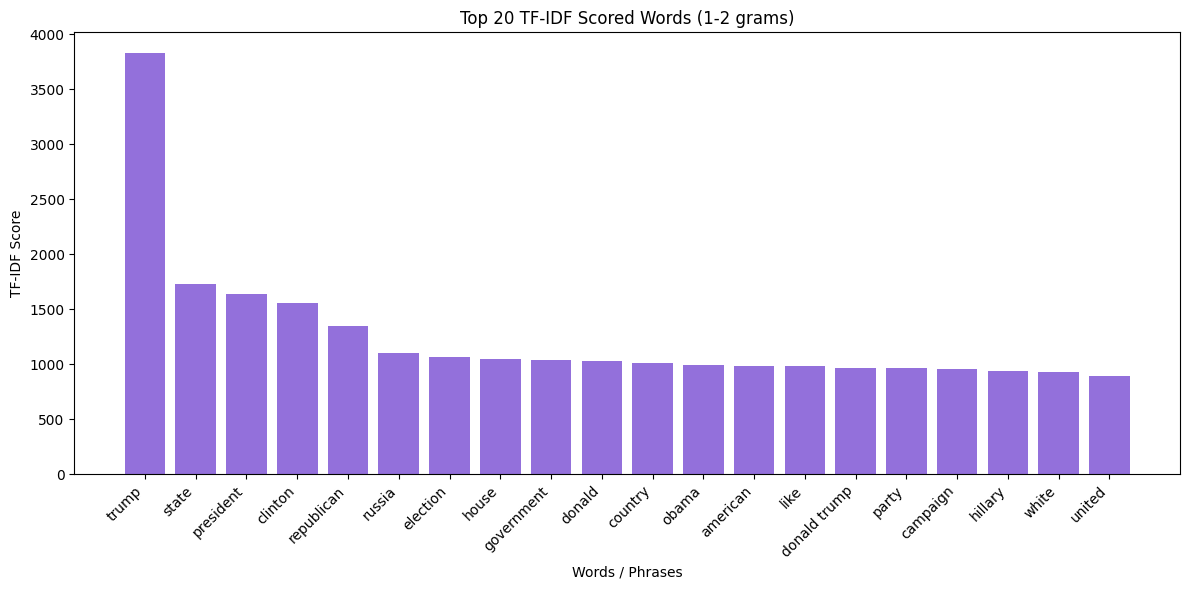

In [ ]:
# Fit TF-IDF on entire dataset (for visualization only)
viz_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_all = viz_vectorizer.fit_transform(combined_df['text'])

# Get word list and corresponding TF-IDF sums
feature_names = viz_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(X_all.sum(axis=0)).flatten()

# Create (word, score) pairs
word_scores = list(zip(feature_names, tfidf_scores))

# Sort and get top 20
top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:20]
words, scores = zip(*top_words)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(words, scores, color='mediumpurple')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 TF-IDF Scored Words (1-2 grams)')
plt.xlabel('Words / Phrases')
plt.ylabel('TF-IDF Score')
plt.tight_layout()
plt.show()


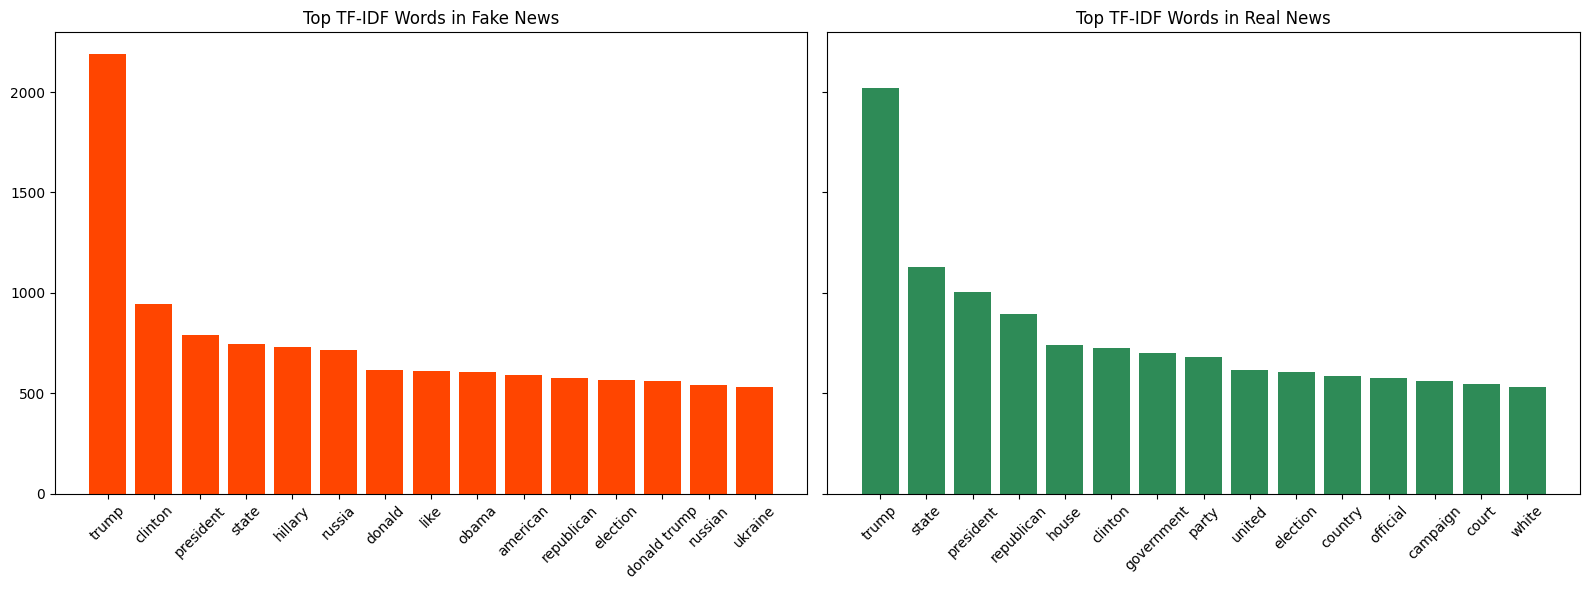

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Separate fake and real articles
fake_texts = combined_df[combined_df['label'] == 0]['text']
real_texts = combined_df[combined_df['label'] == 1]['text']

# Initialize and fit separate TF-IDF vectorizers
vectorizer_fake = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)
vectorizer_real = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)

X_fake = vectorizer_fake.fit_transform(fake_texts)
X_real = vectorizer_real.fit_transform(real_texts)

# Function to get top n TF-IDF words
def get_top_words(X, vectorizer, n=15):
    features = vectorizer.get_feature_names_out()
    scores = np.asarray(X.sum(axis=0)).flatten()
    word_scores = list(zip(features, scores))
    word_scores.sort(key=lambda x: x[1], reverse=True)
    return word_scores[:n]

# Get top words
top_fake = get_top_words(X_fake, vectorizer_fake)
top_real = get_top_words(X_real, vectorizer_real)

# Split into words and scores
fake_words, fake_scores = zip(*top_fake)
real_words, real_scores = zip(*top_real)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Fake News
axes[0].bar(fake_words, fake_scores, color='orangered')
axes[0].set_title('Top TF-IDF Words in Fake News')
axes[0].tick_params(axis='x', rotation=45)

# Real News
axes[1].bar(real_words, real_scores, color='seagreen')
axes[1].set_title('Top TF-IDF Words in Real News')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


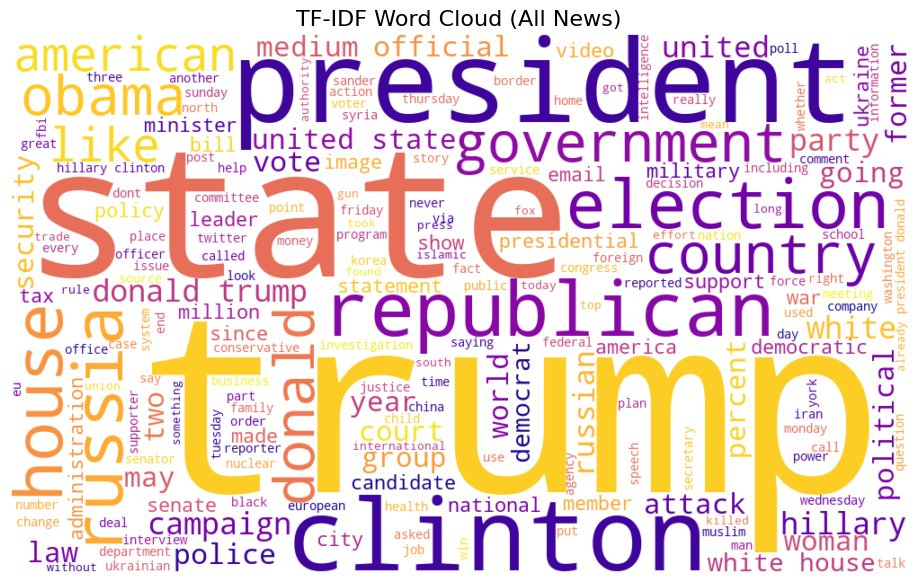

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Use the same TF-IDF vectorizer from earlier
tfidf_scores = X_all.sum(axis=0).A1  # .A1 flattens the matrix to a 1D array
tfidf_vocab = viz_vectorizer.get_feature_names_out()

# Create dictionary: word -> tfidf score
tfidf_dict = dict(zip(tfidf_vocab, tfidf_scores))

# Generate word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='plasma').generate_from_frequencies(tfidf_dict)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('TF-IDF Word Cloud (All News)', fontsize=16)
plt.show()


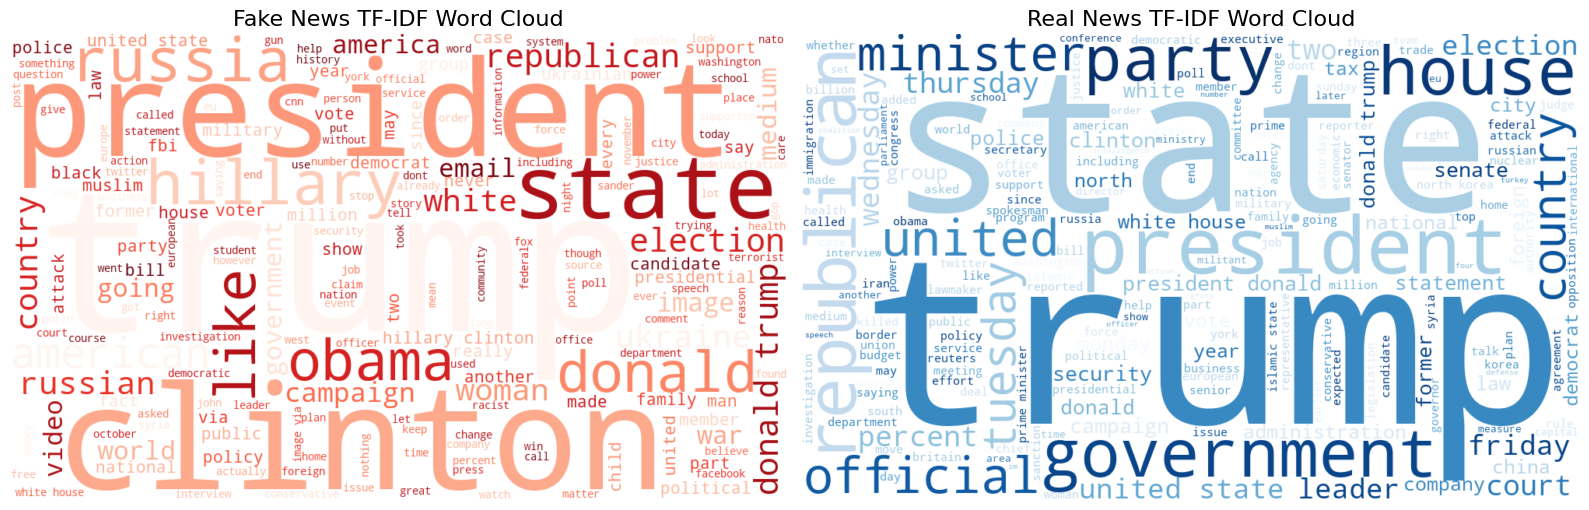

In [19]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)

# Vectorize fake and real articles
X_fake = vectorizer.fit_transform(fake_texts)
X_real = vectorizer.transform(real_texts)

# Get the feature names (words/phrases) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Sum the TF-IDF scores for each word/phrase in fake and real news
fake_tfidf_scores = np.asarray(X_fake.sum(axis=0)).flatten()
real_tfidf_scores = np.asarray(X_real.sum(axis=0)).flatten()

# Create dictionaries for the word and its corresponding TF-IDF score
fake_tfidf_dict = dict(zip(feature_names, fake_tfidf_scores))
real_tfidf_dict = dict(zip(feature_names, real_tfidf_scores))

# Generate word clouds for fake and real news
fake_wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='Reds').generate_from_frequencies(fake_tfidf_dict)
real_wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='Blues').generate_from_frequencies(real_tfidf_dict)

# Plot the word clouds side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot fake news word cloud
axes[0].imshow(fake_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Fake News TF-IDF Word Cloud', fontsize=16)

# Plot real news word cloud
axes[1].imshow(real_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Real News TF-IDF Word Cloud', fontsize=16)

plt.tight_layout()
plt.show()


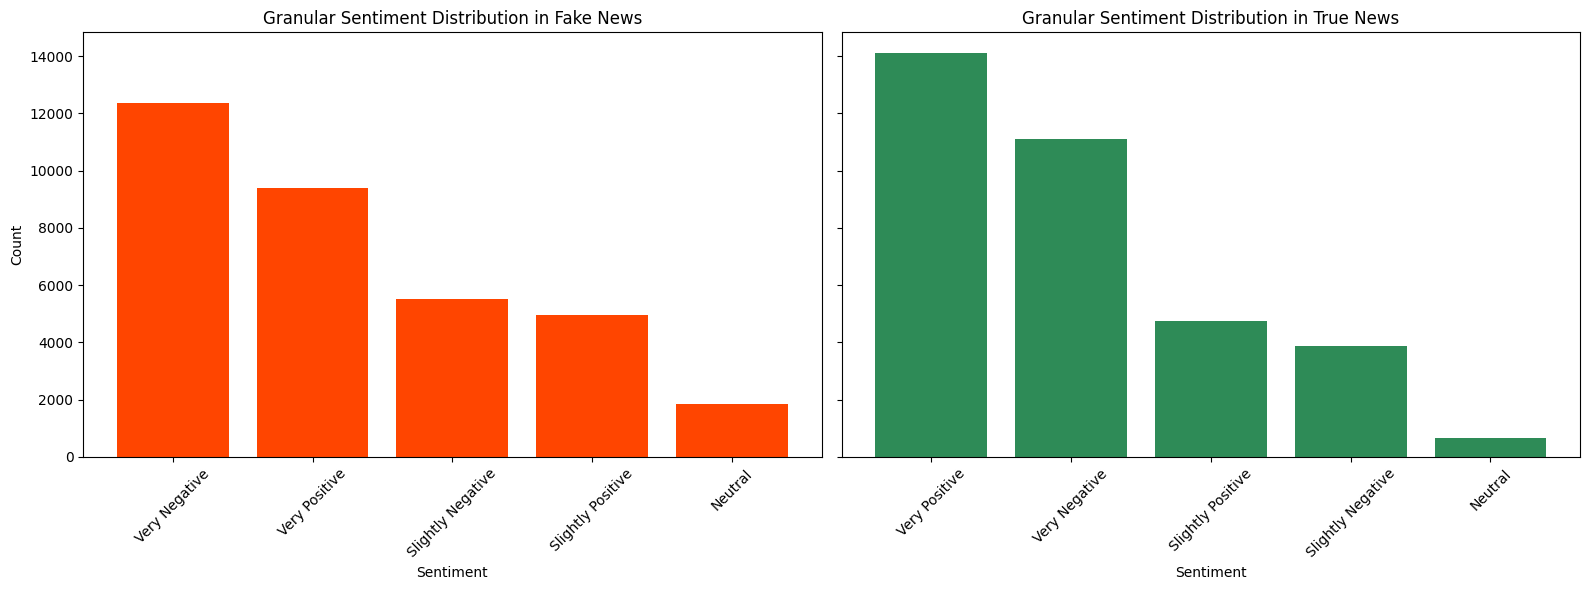

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
# Valence Aware Dictionary and sEntiment Reasoner
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

#  granular sentiment
def get_granular_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    compound_score = sentiment_score['compound']
    
    if compound_score >= 0.75:
        return 'Very Positive'
    elif compound_score >= 0.05:
        return 'Slightly Positive'
    elif compound_score <= -0.75:
        return 'Very Negative'
    elif compound_score <= -0.05:
        return 'Slightly Negative'
    else:
        return 'Neutral'

# Apply the granular sentiment analysis on the text column for both true and fake news
combined_df['granular_sentiment'] = combined_df['text'].apply(get_granular_sentiment)

# Separate the true and fake news articles
fake_df = combined_df[combined_df['label'] == 0]
true_df = combined_df[combined_df['label'] == 1]

# Get sentiment distribution for fake and true news
fake_sentiment_counts = fake_df['granular_sentiment'].value_counts()
true_sentiment_counts = true_df['granular_sentiment'].value_counts()

# Plot sentiment distribution for both fake and true news
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Fake News Sentiment
axes[0].bar(fake_sentiment_counts.index, fake_sentiment_counts.values, color='orangered')
axes[0].set_title('Granular Sentiment Distribution in Fake News')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# True News Sentiment
axes[1].bar(true_sentiment_counts.index, true_sentiment_counts.values, color='seagreen')
axes[1].set_title('Granular Sentiment Distribution in True News')
axes[1].set_xlabel('Sentiment')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Load model and tokenizer
model_name = "monologg/bert-base-cased-goemotions-original"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
 
# Load labels
labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

# Function to extract emotions
def extract_emotions(text, threshold=0.3):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = F.sigmoid(logits)[0].tolist()
    return [labels[i] for i, prob in enumerate(probs) if prob > threshold]

# Apply to your dataset
tqdm.pandas()
combined_df_emotions=combined_df
combined_df_emotions["emotions"] = combined_df_emotions["text"].progress_apply(lambda x: extract_emotions(x))

# Count emotions by label (0 = real, 1 = fake)
def count_emotions_by_class(df):
    emotion_counts = {0: {}, 1: {}}
    for label in [0, 1]:
        subset = df[df["label"] == label]["emotions"]
        for emotions in subset:
            for emo in emotions:
                if emo not in emotion_counts[label]:
                    emotion_counts[label][emo] = 0
                emotion_counts[label][emo] += 1
    return emotion_counts


/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 68604/68604 [5:43:44<00:00,  3.33it/s]      


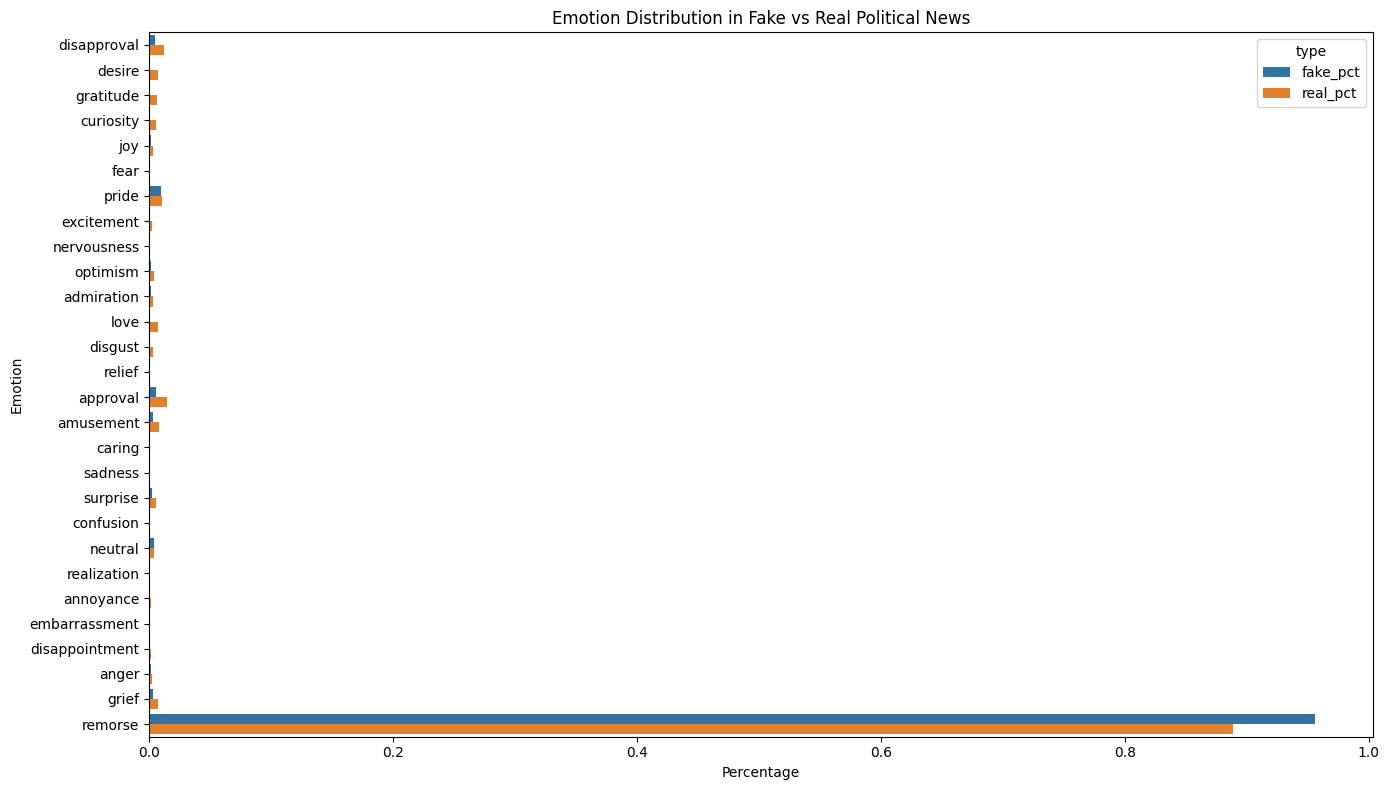

In [22]:
# error from here
emotion_counts = count_emotions_by_class(combined_df_emotions)

# Convert to DataFrame for visualization
emotion_df = pd.DataFrame({
    "emotion": list(set(labels)),
    "fake": [emotion_counts[1].get(e, 0) for e in labels],
    "real": [emotion_counts[0].get(e, 0) for e in labels]
})

emotion_df.to_csv("emotion_counts.csv", index=False)

# Normalize if needed
emotion_df["fake_pct"] = emotion_df["fake"] / emotion_df["fake"].sum()
emotion_df["real_pct"] = emotion_df["real"] / emotion_df["real"].sum()

# Melt for seaborn
emotion_plot_df = emotion_df.melt(id_vars="emotion", value_vars=["fake_pct", "real_pct"],
                                   var_name="type", value_name="percentage")

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=emotion_plot_df, x="percentage", y="emotion", hue="type")
plt.title("Emotion Distribution in Fake vs Real Political News")
plt.xlabel("Percentage")
plt.ylabel("Emotion")
plt.tight_layout()
plt.show()

In [23]:
# Latent Dirichlet Allocation
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis    
from nltk.tokenize import word_tokenize

# Tokenize the preprocessed text
tokenized_docs = combined_df['text'].apply(lambda x: word_tokenize(x))

# Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Build LDA model
num_topics = 5
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=15
)

# Print top keywords for each topic
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"\n Topic {idx+1}:", topic)

# Save to HTML for visualization
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_topic_modeling_all.html')



 Topic 1: 0.031*"trump" + 0.012*"clinton" + 0.012*"republican" + 0.010*"president" + 0.008*"campaign" + 0.007*"party" + 0.007*"state" + 0.005*"candidate" + 0.005*"house" + 0.005*"election"

 Topic 2: 0.013*"state" + 0.008*"united" + 0.007*"country" + 0.007*"government" + 0.007*"military" + 0.006*"iran" + 0.006*"official" + 0.006*"minister" + 0.006*"islamic" + 0.006*"president"

 Topic 3: 0.013*"court" + 0.010*"state" + 0.009*"law" + 0.008*"department" + 0.008*"official" + 0.007*"case" + 0.006*"justice" + 0.006*"email" + 0.006*"federal" + 0.006*"investigation"

 Topic 4: 0.007*"police" + 0.005*"like" + 0.005*"m" + 0.004*"woman" + 0.004*"city" + 0.004*"two" + 0.004*"family" + 0.003*"man" + 0.003*"black" + 0.003*"year"

 Topic 5: 0.006*"state" + 0.005*"company" + 0.005*"percent" + 0.004*"million" + 0.004*"year" + 0.004*"like" + 0.004*"american" + 0.003*"health" + 0.003*"tax" + 0.003*"government"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [24]:
# === Tokenize Fake & Real ===
fake_tokenized = fake_texts.apply(word_tokenize)
real_tokenized = real_texts.apply(word_tokenize)

# === FAKE NEWS LDA ===
fake_dict = corpora.Dictionary(fake_tokenized)
fake_corpus = [fake_dict.doc2bow(text) for text in fake_tokenized]

lda_model_fake = models.LdaModel(
    corpus=fake_corpus,
    id2word=fake_dict,
    num_topics=5,
    random_state=42,
    passes=15
)
print("\n=== 🧨 Topics in FAKE News ===")
for idx, topic in lda_model_fake.print_topics(num_words=10):
    print(f"Fake Topic {idx + 1}:", topic)

vis_fake = gensimvis.prepare(lda_model_fake, fake_corpus, fake_dict)
pyLDAvis.save_html(vis_fake, 'lda_fake_news.html')

# === REAL NEWS LDA ===
real_dict = corpora.Dictionary(real_tokenized)
real_corpus = [real_dict.doc2bow(text) for text in real_tokenized]

lda_model_real = models.LdaModel(
    corpus=real_corpus,
    id2word=real_dict,
    num_topics=5,
    random_state=42,
    passes=15
)
print("\n=== ✅ Topics in REAL News ===")
for idx, topic in lda_model_real.print_topics(num_words=10):
    print(f"Real Topic {idx + 1}:", topic)

vis_real = gensimvis.prepare(lda_model_real, real_corpus, real_dict)
pyLDAvis.save_html(vis_real, 'lda_real_news.html')


=== 🧨 Topics in FAKE News ===
Fake Topic 1: 0.009*"russia" + 0.007*"state" + 0.007*"war" + 0.006*"russian" + 0.005*"world" + 0.005*"country" + 0.005*"government" + 0.004*"ukraine" + 0.004*"military" + 0.004*"american"
Fake Topic 2: 0.029*"de" + 0.017*"la" + 0.014*"в" + 0.011*"и" + 0.009*"en" + 0.009*"que" + 0.009*"el" + 0.006*"что" + 0.006*"на" + 0.005*"le"
Fake Topic 3: 0.030*"trump" + 0.021*"clinton" + 0.014*"hillary" + 0.010*"election" + 0.008*"president" + 0.008*"donald" + 0.007*"email" + 0.007*"campaign" + 0.005*"obama" + 0.005*"republican"
Fake Topic 4: 0.006*"like" + 0.004*"woman" + 0.004*"police" + 0.003*"black" + 0.003*"child" + 0.003*"man" + 0.003*"dont" + 0.002*"video" + 0.002*"white" + 0.002*"school"
Fake Topic 5: 0.013*"state" + 0.011*"law" + 0.008*"federal" + 0.007*"court" + 0.007*"government" + 0.006*"department" + 0.005*"case" + 0.005*"justice" + 0.005*"fbi" + 0.004*"million"

=== ✅ Topics in REAL News ===
Real Topic 1: 0.006*"like" + 0.004*"m" + 0.004*"year" + 0.004*"

# Classification models

## Naive bayes model

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split Data Into Training and Testing Sets
x_train, x_test, y_train, y_test = train_test_split(
    combined_df['text'], combined_df['label'], 
    test_size=0.2, random_state=50,
)

# Initialize Vectorizer and Vectorize Data
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [26]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Model
classifier = MultinomialNB()

# Train the Model
classifier.fit(x_train_vectorized, y_train)

MultinomialNB()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.82      6881
           1       0.78      0.96      0.86      6840

    accuracy                           0.84     13721
   macro avg       0.86      0.84      0.84     13721
weighted avg       0.86      0.84      0.84     13721


Cross-Validated Accuracy (5-fold): 0.7
Cross-Validated F1 Score (5-fold): 0.74


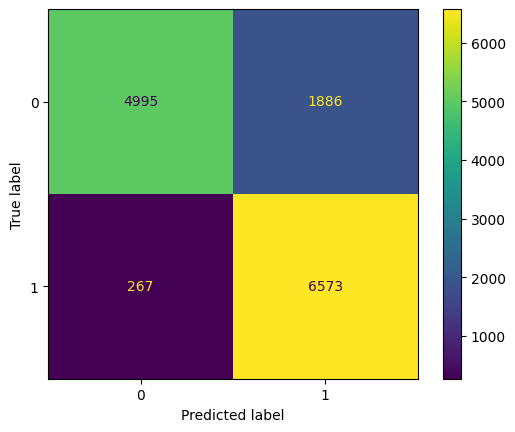

In [27]:
# === PIPELINE ===
text_clf = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(x_test)

# === EVALUATION ===

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# === CROSS-VALIDATION ===

cv_results = cross_validate(
    text_clf, 
    combined_df['text'], 
    combined_df['label'], 
    cv=5,
    scoring=['accuracy', 'f1'],
    return_train_score=False
)

print("\nCross-Validated Accuracy (5-fold):", round(cv_results['test_accuracy'].mean(), 2))
print("Cross-Validated F1 Score (5-fold):", round(cv_results['test_f1'].mean(), 2))

## LSTM Code

/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
687/687 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.5757 - loss: 0.6720 - val_accuracy: 0.7461 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 2/100
687/687 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.7030 - loss: 0.5962 - val_accuracy: 0.5740 - val_loss: 0.6650 - learning_rate: 0.0010
Epoch 3/100
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.5589 - loss: 0.6759 - val_accuracy: 0.5776 - val_loss: 0.6522 - learning_rate: 0.0010
Epoch 4/100
687/687 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.5572 - loss: 0.6691 - val_accuracy: 0.5558 - val_loss: 0.6588 - learning_rate: 0.0010
Epoch 5/100
687/687 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - accuracy: 0.5729 - loss: 0.6551 - val_accuracy: 0.5814 - val_loss: 0.6466 - learning_rate: 0.0010
Epoch 6/100
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6504 - loss: 0.6049
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
687/687 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.6505

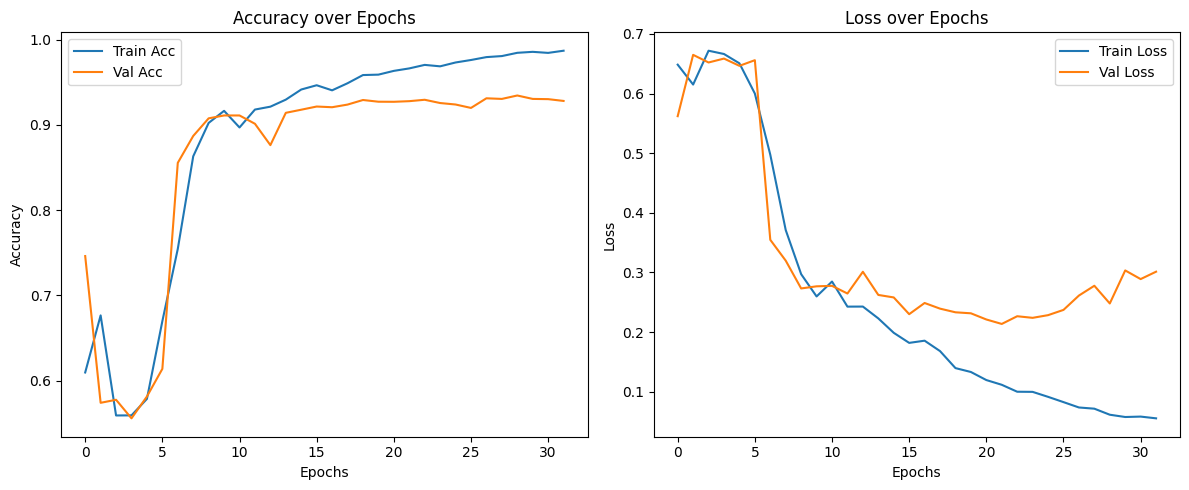

In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# === TOKENIZATION ===
max_vocab = 10000
max_len = 250

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_df['text'])
sequences = tokenizer.texts_to_sequences(combined_df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# === SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, combined_df['label'].values, test_size=0.2, random_state=42, stratify=combined_df['label'])

# === LSTM MODEL ===
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# === EARLY STOPPING ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Reduce learning rate when val_accuracy plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,                # reduce by half
    patience=5,                # wait 5 epochs with no improvement
    verbose=1,
    min_lr=1e-6                # don't go below this
)

# === TRAIN ===
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# === EVALUATE ===
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# === PLOT TRAINING HISTORY ===
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.tight_layout()
plt.show()


### K-fold cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold = 1
all_y_true = []
all_y_pred = []

for train_index, val_index in kf.split(padded_sequences,combined_df['label'].values):
    print(f"\n===== Fold {fold} =====")
    
    X_train, X_val = padded_sequences[train_index], padded_sequences[val_index]
    y_train, y_val = combined_df['label'].values[train_index], combined_df['label'].values[val_index]

    # Reinitialize the model
    model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # === EARLY STOPPING ===
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


    # Reduce learning rate when val_accuracy plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,                # reduce by half
        patience=5,                # wait 5 epochs with no improvement
        verbose=1,
        min_lr=1e-6                # don't go below this
    )

    # === TRAIN ===
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, reduce_lr]
    )

    y_pred = (model.predict(X_val) > 0.5).astype("int32").flatten()
    print(classification_report(y_val, y_pred))
    
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    fold += 1

model.summary()
# === Overall Performance ===
print("\n===== Overall Performance Across Folds =====")
print(classification_report(all_y_true, all_y_pred))



===== Fold 1 =====
Epoch 1/100


/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


858/858 ━━━━━━━━━━━━━━━━━━━━ 57s 64ms/step - accuracy: 0.5726 - loss: 0.6708 - val_accuracy: 0.6905 - val_loss: 0.6066 - learning_rate: 0.0010
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.7143 - loss: 0.5749 - val_accuracy: 0.7908 - val_loss: 0.4663 - learning_rate: 0.0010
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 56s 66ms/step - accuracy: 0.7958 - loss: 0.4660 - val_accuracy: 0.8655 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.8914 - loss: 0.2935 - val_accuracy: 0.8937 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.9045 - loss: 0.2489 - val_accuracy: 0.9286 - val_loss: 0.1891 - learning_rate: 0.0010
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 61s 71ms/step - accuracy: 0.9399 - loss: 0.1644 - val_accuracy: 0.9363 - val_loss: 0.1843 - learning_rate: 0.0010
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - accuracy: 0.9587 - loss: 

/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


858/858 ━━━━━━━━━━━━━━━━━━━━ 51s 57ms/step - accuracy: 0.5642 - loss: 0.6750 - val_accuracy: 0.5765 - val_loss: 0.6761 - learning_rate: 0.0010
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.5782 - loss: 0.6684 - val_accuracy: 0.6239 - val_loss: 0.5869 - learning_rate: 0.0010
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 51s 60ms/step - accuracy: 0.7315 - loss: 0.5563 - val_accuracy: 0.6083 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 51s 60ms/step - accuracy: 0.6535 - loss: 0.6023 - val_accuracy: 0.7007 - val_loss: 0.6084 - learning_rate: 0.0010
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 52s 60ms/step - accuracy: 0.8175 - loss: 0.4504 - val_accuracy: 0.8625 - val_loss: 0.3481 - learning_rate: 0.0010
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.8920 - loss: 0.3202 - val_accuracy: 0.9064 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9211 - loss: 

/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 54ms/step - accuracy: 0.5763 - loss: 0.6745 - val_accuracy: 0.7073 - val_loss: 0.5961 - learning_rate: 0.0010
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.6089 - loss: 0.6582 - val_accuracy: 0.8576 - val_loss: 0.4132 - learning_rate: 0.0010
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.8362 - loss: 0.4394 - val_accuracy: 0.6583 - val_loss: 0.5828 - learning_rate: 0.0010
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 55s 64ms/step - accuracy: 0.6842 - loss: 0.5790 - val_accuracy: 0.8598 - val_loss: 0.3799 - learning_rate: 0.0010
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 1192s 1s/step - accuracy: 0.7986 - loss: 0.4698 - val_accuracy: 0.8826 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 9115s 11s/step - accuracy: 0.8707 - loss: 0.3394 - val_accuracy: 0.8706 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 2564s 3s/step - accuracy: 0.8833 - loss:

/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


858/858 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.5784 - loss: 0.6797 - val_accuracy: 0.6602 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - accuracy: 0.6902 - loss: 0.5972 - val_accuracy: 0.8351 - val_loss: 0.4243 - learning_rate: 0.0010
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 54s 63ms/step - accuracy: 0.8509 - loss: 0.4067 - val_accuracy: 0.8755 - val_loss: 0.3158 - learning_rate: 0.0010
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.8561 - loss: 0.3665 - val_accuracy: 0.9079 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.8885 - loss: 0.3141 - val_accuracy: 0.9186 - val_loss: 0.2547 - learning_rate: 0.0010
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 59s 69ms/step - accuracy: 0.9292 - loss: 0.2343 - val_accuracy: 0.9188 - val_loss: 0.2379 - learning_rate: 0.0010
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.9307 - loss: 

/Users/gunturuvarsha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


858/858 ━━━━━━━━━━━━━━━━━━━━ 47s 53ms/step - accuracy: 0.5830 - loss: 0.6712 - val_accuracy: 0.6352 - val_loss: 0.6124 - learning_rate: 0.0010
Epoch 2/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.6483 - loss: 0.5905 - val_accuracy: 0.6851 - val_loss: 0.5828 - learning_rate: 0.0010
Epoch 3/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 53s 61ms/step - accuracy: 0.6868 - loss: 0.5853 - val_accuracy: 0.7334 - val_loss: 0.5604 - learning_rate: 0.0010
Epoch 4/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 52s 60ms/step - accuracy: 0.7328 - loss: 0.5586 - val_accuracy: 0.8156 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 5/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.8402 - loss: 0.3901 - val_accuracy: 0.9024 - val_loss: 0.2527 - learning_rate: 0.0010
Epoch 6/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 68ms/step - accuracy: 0.9110 - loss: 0.2444 - val_accuracy: 0.9098 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 7/100
858/858 ━━━━━━━━━━━━━━━━━━━━ 58s 67ms/step - accuracy: 0.9316 - loss: 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,025,413 (7.73 MB)

 Trainable params: 675,137 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,350,276 (5.15 MB)


===== Overall Performance Across Folds =====
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     34078
           1       0.94      0.94      0.94     34526

    accuracy                           0.94     68604
   macro avg       0.94      0.94      0.94     68604
weighted avg       0.94      0.94      0.94     68604



429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


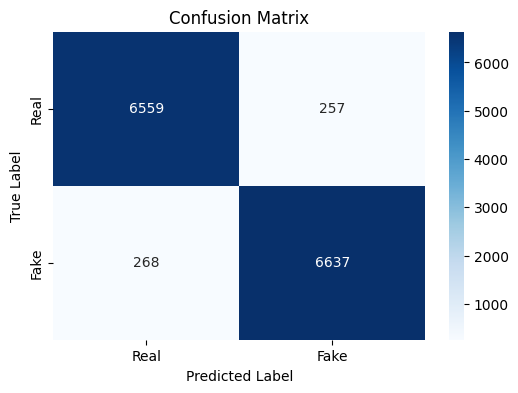

429/429 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


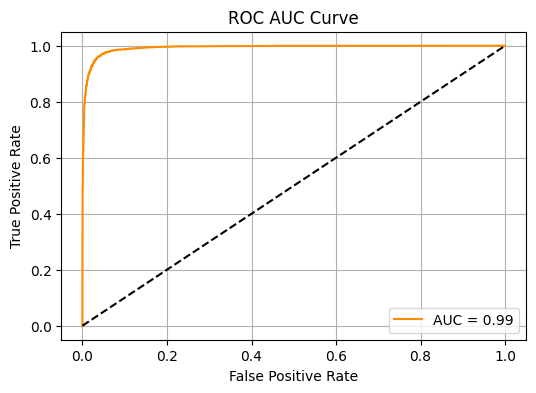

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_curve, auc

# Get probability predictions instead of binary ones
y_proba = model.predict(X_test).ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [24]:
model.save("lstm_fake_news_detection_model.h5")
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,025,413 (7.73 MB)

 Trainable params: 675,137 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,350,276 (5.15 MB)